<a href="https://colab.research.google.com/github/wbandabarragan/EPIC_3/blob/main/EPIC_Junior/Hydrogen_atom_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hydrogen atom orbitals

---



---



Original source: https://github.com/sebastianmagns/hydrogen-wavefunctions

In [ ]:
#!pip install seaborn


In [ ]:

from scipy.constants import physical_constants
import matplotlib.pyplot as plt
import scipy.special as sp
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact


In [ ]:
def radial_function(n, l, r, a0):
    """ Compute the normalized radial part of the wavefunction using
    Laguerre polynomials and an exponential decay factor.

    Args:
        n (int): principal quantum number
        l (int): azimuthal quantum number
        r (numpy.ndarray): radial coordinate
        a0 (float): scaled Bohr radius
    Returns:
        numpy.ndarray: wavefunction radial component
    """

    laguerre = sp.genlaguerre(n - l - 1, 2 * l + 1)
    p = 2 * r / (n * a0)

    constant_factor = np.sqrt(
        ((2 / n * a0) ** 3 * (sp.factorial(n - l - 1))) /
        (2 * n * (sp.factorial(n + l)))
    )
    return constant_factor * np.exp(-p / 2) * (p ** l) * laguerre(p)



In [ ]:
def angular_function(m, l, theta, phi):
    """ Compute the normalized angular part of the wavefunction using
    Legendre polynomials and a phase-shifting exponential factor.

    Args:
        m (int): magnetic quantum number
        l (int): azimuthal quantum number
        theta (numpy.ndarray): polar angle
        phi (int): azimuthal angle
    Returns:
        numpy.ndarray: wavefunction angular component
    """

    legendre = sp.lpmv(m, l, np.cos(theta))

    constant_factor = ((-1) ** m) * np.sqrt(
        ((2 * l + 1) * sp.factorial(l - np.abs(m))) /
        (4 * np.pi * sp.factorial(l + np.abs(m)))
    )
    return constant_factor * legendre * np.real(np.exp(1.j * m * phi))




In [ ]:
def compute_wavefunction(n, l, m, a0_scale_factor):
    """ Compute the normalized wavefunction as a product
    of its radial and angular components.

    Args:
        n (int): principal quantum number
        l (int): azimuthal quantum number
        m (int): magnetic quantum number
        a0_scale_factor (float): Bohr radius scale factor
    Returns:
        numpy.ndarray: wavefunction
    """

    # Scale Bohr radius for effective visualization
    a0 = a0_scale_factor * physical_constants['Bohr radius'][0] * 1e+12

    # x-y grid to represent electron spatial distribution
    grid_extent = 480
    grid_resolution = 680
    x = y = np.linspace(-grid_extent, grid_extent, grid_resolution)
    x, y = np.meshgrid(x, y)

    # Use epsilon to avoid division by zero during angle calculations
    eps = np.finfo(float).eps

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    psi = radial_function(
        n, l, np.sqrt((x ** 2 + y ** 2)), a0
    ) * angular_function(
        m, l, np.arctan(x / (y + eps)), 0
    )
    return psi


In [ ]:
def compute_probability_density(psi):
    """ Compute the probability density of a given wavefunction.
    Args:
        psi (numpy.ndarray): wavefunction
    Returns:
        numpy.ndarray: wavefunction probability density
    """
    return np.abs(psi) ** 2



In [ ]:
def plot_wf_probability_density(n, l, m, a0_scale_factor, dark_theme=False, color_palette='rocket'):
    """ Plot the probability density of the hydrogen
    atom's wavefunction for a given quantum state (n,l,m).

    Args:
        n (int): principal quantum number, determines the energy level and size of the orbital
        l (int): azimuthal quantum number, defines the shape of the orbital
        m (int): magnetic quantum number, defines the orientation of the orbital
        a0_scale_factor (float): Bohr radius scale factor
        dark_theme (bool): If True, uses a dark background for the plot, defaults to False
        color_palette (str): Seaborn plot color palette, defaults to 'rocket'
    """

    # Quantum numbers validation
    if not isinstance(n, int) or n < 1:
        raise ValueError('n should be an integer satisfying the condition: n >= 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l should be an integer satisfying the condition: 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m should be an integer satisfying the condition: -l <= m <= l')

    # Color palette validation
    try:
        sns.color_palette(color_palette)
    except ValueError:
        raise ValueError(f'{color_palette} is not a recognized Seaborn color palette.')

    fig, ax = plt.subplots(figsize=(5, 5.5))
    plt.subplots_adjust(top=0.82)
    plt.subplots_adjust(right=0.905)
    plt.subplots_adjust(left=-0.1)

    # Compute and visualize the wavefunction probability density
    psi = compute_wavefunction(n, l, m, a0_scale_factor)
    prob_density = compute_probability_density(psi)
    im = ax.imshow(np.sqrt(prob_density), cmap=sns.color_palette(color_palette, as_cmap=True))

    cbar = plt.colorbar(im, fraction=0.046, pad=0.03)
    cbar.set_ticks([])

    # Apply dark theme parameters
    if dark_theme:
        theme = 'dt'
        background_color = sorted(
            sns.color_palette(color_palette, n_colors=100),
            key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
        )[0]
        plt.rcParams['text.color'] = '#dfdfdf'
        title_color = '#dfdfdf'
        fig.patch.set_facecolor(background_color)
        cbar.outline.set_visible(False)
        ax.tick_params(axis='x', colors='#c4c4c4')
        ax.tick_params(axis='y', colors='#c4c4c4')
        for spine in ax.spines.values():
            spine.set_color('#c4c4c4')

    else:  # Apply light theme parameters
        theme = 'lt'
        plt.rcParams['text.color'] = '#000000'
        title_color = '#000000'
        ax.tick_params(axis='x', colors='#000000')
        ax.tick_params(axis='y', colors='#000000')

    ax.text(30, 615, r'$({0}, {1}, {2})$'.format(n, l, m), color='#dfdfdf', fontsize=22)
    ax.invert_yaxis()

    # Save and display the plot
    plt.savefig(f'({n},{l},{m})[{theme}].png')
    plt.show()


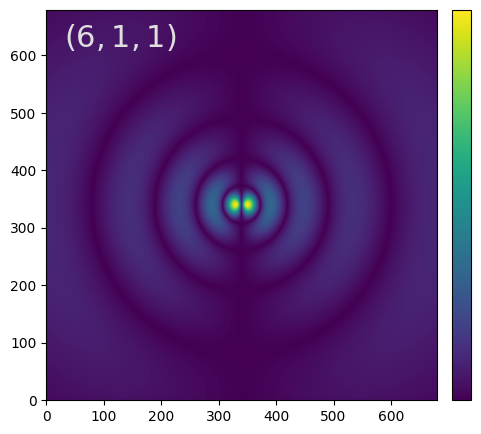

In [ ]:
n=6
l=1
m=1
a0_scale_factor=1/n

plot1 = plot_wf_probability_density(n, l, m, a0_scale_factor, dark_theme=False, color_palette='viridis')

# Imagen interactiva

n puede tomar cualquier valor del 0 al 10 (entre más número pongas más se tarda en generar la imagen interactiva debido al coste computacional)

color_a nos permite cambiar el color de la imagen sólo acepta las siguientes opciones: "rocket", "viridis", "Spectral", "magma" "ch:s=.25,rot=-.25", y otros

In [ ]:
n_value = 4
color_a = "magma"

In [ ]:
# Función interactiva para actualizar los plots en tiempo real
def interactive_plot(n, l, m):
    a0_scale_factor = 1 / n  # Calcula el a0_scale_factor en función de n

    plot = plot_wf_probability_density(n, l, m, a0_scale_factor, dark_theme=False, color_palette=color_a)
    plt.show()

# Crea controles deslizantes para n, l, y m
n_slider = widgets.IntSlider(value=n, min=1, max=n_value, description='n')
l_slider = widgets.IntSlider(value=0, min=0, max=n_slider.value-1, description='l')
m_slider = widgets.IntSlider(value=0, min=-l_slider.value, max=l_slider.value, description='m')

# Define función para actualizar l_slider cuando cambia n_slider
def update_l_range(change):
    l_slider.max = change.new - 1
    l_slider.value = max(l_slider.value, 0)  # Asegura que el valor de l se mantenga dentro del nuevo rango
    update_m_range(None)  # Actualiza el rango de m al cambiar l

# Vincula la función de actualización a cambios en n_slider
n_slider.observe(update_l_range, names='value')

# Define función para actualizar m_slider cuando cambia l_slider
def update_m_range(change):
    m_slider.min = -l_slider.value  # Ajusta el valor mínimo de m en función de l
    m_slider.max = l_slider.value
    m_slider.value = max(min(m_slider.value, m_slider.max), m_slider.min)  # Asegura que el valor de m esté dentro del rango permitido

# Vincula la función de actualización a cambios en l_slider
l_slider.observe(update_m_range, names='value')

# Crea la interfaz interactiva utilizando la función interact
interact(interactive_plot, n=n_slider, l=l_slider, m=m_slider)


interactive(children=(IntSlider(value=4, description='n', max=4, min=1), IntSlider(value=0, description='l', m…

<function __main__.interactive_plot(n, l, m)>